# Exploratory analysis

Man Ho Wong | March 24, 2022

# Overview

Goal of this notebook

Table of contents

In [1]:
# Python libraries and packages required
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                    # For pretty printing
import pylangacq                 # For reading CHAT files
from tqdm import tqdm            # For showing progress bar
from wordcloud import WordCloud as wc

# use ggplot style for figures
plt.style.use('ggplot')

# Unpickle data
data_idx = pickle.load(open('../data/childes/corpus_info.pkl', 'rb'))

# Pretty printing for better readability
# With this, you can print dict in compact format instead of one item
#   per line. Items will be in alphabetical order. Nested Dict will be printed 
#   with suitable indentation. It will also print Counter in descending order.
#   To use this, call cp.pprint()
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

# Function to convert age from year-month-day tuple to age in months
def get_age_m(ymd):
    age_m = ymd[0]*12 + ymd[1] + round(ymd[2]/30,1)
    return age_m

data_idx.head()

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,Bates_Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,Bates_Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,Bates_Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,Bates_Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,Bates_Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


---

# 1 Mean length of utterance (MLU) by morpheme

In [2]:
# Read one sample file for testing
f = data_idx[data_idx.ses == 'UC'].file_path.iloc[0]
sample = pylangacq.Reader.from_files([f], parallel=False)

## Self-defined function to get MLU-M for different word classes

In [3]:
# Function to get mlum by POS
#   similar to pylangacq's reader method mlum()
def get_mlum(reader, participants, pos=1):
    tok_by_utt = reader.tokens(participants=participants, by_utterances=True)
    POS_TO_IGNORE = ["", "!", "+...", "0", "?", "BEG", ".", None]
    n_utt = 0
    n_mor = 0
    for utt in tok_by_utt:
        current_mor_count = n_mor
        for tok in utt:
            if (tok.pos not in POS_TO_IGNORE) and (pos==1 or tok.pos in pos):
                n_mor += 1
                if type(tok.mor) == str:
                    n_mor += tok.mor.count('-')
                    n_mor += tok.mor.count('~')
        if n_mor > current_mor_count:
            n_utt += 1
    if n_utt: 
        return n_mor/n_utt
    else:
        return 0

# Define POS by open vs close word class
POS_OPEN = ["n", "v", "adv", "adj", "co"]
POS_CLOSE = ['mod', 'neg', 'cop', 'pro:exist', 'aux', 'part', 'det:art', 'comp',
             'post','pro:obj', 'pro:int', 'pro:per', 'coord', 'on', 'inf', 'qn',
             'pro:indef', 'pro:sub', 'pro:rel', 'prep', 'pro:dem', 'det:num']

# Example
get_mlum(sample, 'MOT')

6.9523809523809526

## Comparing MLU-M between open and close class words in upper-class children

In [4]:
mlum_list_open = []
mlum_list_close = []
ages = []
for f in tqdm(data_idx[data_idx.ses == 'UC'].file_path):
    sample = pylangacq.Reader.from_files([f], parallel=False)
    mlum_list_open.append(get_mlum(sample, 'CHI', POS_OPEN))
    mlum_list_close.append(get_mlum(sample, 'CHI', POS_CLOSE))
    ages.append(get_age_m(sample.ages()[0]))

df = pd.DataFrame({'open':mlum_list_open, 'close':mlum_list_close})

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:32<00:00,  2.09it/s]


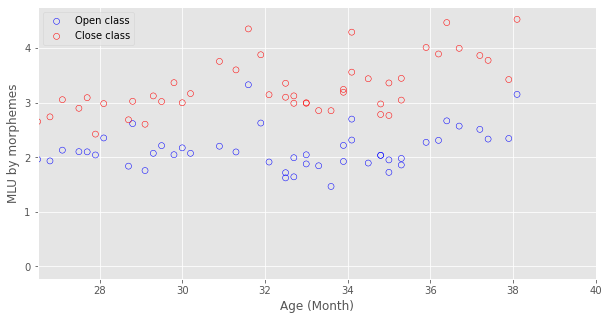

In [5]:
plt.figure(figsize=(10,5))
plt.scatter(ages,df.open,facecolors='none', edgecolors='b')
plt.scatter(ages,df.close,facecolors='none', edgecolors='r')
plt.xlabel('Age (Month)')
plt.ylabel('MLU by morphemes')
plt.xlim([min(ages), 40])
plt.legend(['Open class', 'Close class'])

---

# 2 TTR

## Self-defined function to get type-to-token ratio (TTR)

In [6]:
# TTR of CHI (same as sample.ttr())
def get_ttr(reader, participants, pos=1):
    toks = reader.tokens(participants=participants)
    WORDS_TO_IGNORE = ["", "!", "+...", ".", ",", "?", "‡", "„", "0", "CLITIC"]
    tok_list     = [t.word for t in toks if
                   (t.word not in WORDS_TO_IGNORE)]
    tok_list_pos = [t.word for t in toks if
                   (t.word not in WORDS_TO_IGNORE) and (pos==1 or t.pos in pos)]    
    if tok_list:
        return len(set(tok_list_pos))/len(tok_list)
    else:
        return 0

get_ttr(sample, 'CHI', POS_OPEN)

0.09920424403183024

Comparing TTR between open and close class words in upper-class children

In [7]:
ttr_list_open = []
ttr_list_close = []
ages = []
for f in tqdm(data_idx[data_idx.ses=='UC'].file_path):
    sample = pylangacq.Reader.from_files([f], parallel=False)
    ttr_list_open.append(get_ttr(sample, 'CHI', POS_OPEN))
    ttr_list_close.append(get_ttr(sample, 'CHI', POS_CLOSE))
    ages.append(get_age_m(sample.ages()[0]))

df = pd.DataFrame({'open':ttr_list_open, 'close':ttr_list_close})

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:30<00:00,  2.21it/s]


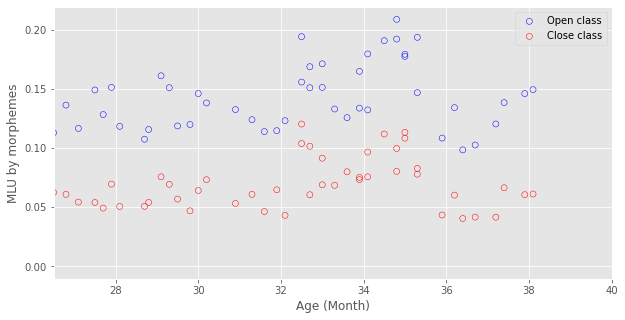

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(ages,df.open,facecolors='none', edgecolors='b')
plt.scatter(ages,df.close,facecolors='none', edgecolors='r')
plt.xlabel('Age (Month)')
plt.ylabel('MLU by morphemes')
plt.xlim([min(ages), 40])
plt.legend(['Open class', 'Close class'])

---

# 3 POS ratio

## Self-defined function to get POS ratio

In [9]:
def get_pos_ratio(reader, participants, pos=1):
    toks = reader.tokens(participants=participants)
    WORDS_TO_IGNORE = ["", "!", "+...", ".", ",", "?", "‡", "„", "0", "CLITIC"]
    tok_list     = [t.word for t in toks if
                   (t.word not in WORDS_TO_IGNORE)]
    tok_list_pos = [t.word for t in toks if
                   (t.word not in WORDS_TO_IGNORE) and (pos==1 or t.pos in pos)]
    if tok_list:
        return len(set(tok_list_pos))/len(set(tok_list))
    else:
        return 0
    
get_pos_ratio(sample, 'CHI', POS_OPEN)

0.6919518963922294

---

# 4 Word frequency

In [10]:
# Read all files of UC children
f = data_idx[data_idx.ses == 'UC'].file_path
f_UC = pylangacq.Reader.from_files(f, parallel=False)

## Getting word frequencies with pylangacq function

In [11]:
freq = f_UC.word_frequencies()
freq.most_common(20)

[('.', 108791),
 ('?', 38547),
 ('you', 28842),
 (',', 25647),
 ('I', 23034),
 ('the', 22485),
 ('it', 17342),
 ('a', 17194),
 ('and', 14434),
 ('that', 10587),
 ('to', 10426),
 ('what', 10166),
 ('yeah', 9588),
 ('!', 9588),
 ('this', 9348),
 ('...', 8558),
 ('is', 8265),
 ('no', 8213),
 ('in', 8073),
 ('on', 7170)]

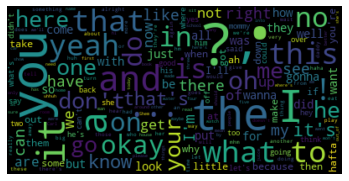

In [12]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

## Self-defined function to get word frequencies by POS and ignore punctuations

In [13]:
# Same as word_frequencies(participants='CHI', by_files=True)[file_idx]
def get_freq(reader, participants='CHI', pos=1, file_idx=0):
    if 'Counter' not in dir():
        from collections import Counter
    WORDS_TO_IGNORE = ["", "!", "+...", ".", ",", "‡", "„", "0", 'CLITIC']
    toks = reader.tokens(participants=participants, by_files=True)[file_idx]
    tok_list_pos = [t.word for t in toks if
                   (t.word not in WORDS_TO_IGNORE) and (pos==1 or t.pos in pos)]
    freq = Counter(tok_list_pos)
    return freq

# get freq of one file in 'sample':
get_freq(f_UC, pos=POS_OPEN, file_idx=2).most_common(20)

[('yeah', 84),
 ('there', 45),
 ('go', 43),
 ('wanna', 38),
 ('want', 36),
 ('uhoh', 22),
 ('make', 20),
 ('here', 19),
 ('no', 18),
 ('down', 16),
 ('do', 15),
 ('see', 14),
 ('oh', 13),
 ('okay', 11),
 ('right', 11),
 ('that', 10),
 ('taperecorder', 10),
 ('car', 10),
 ('daddy', 10),
 ('turn', 9)]

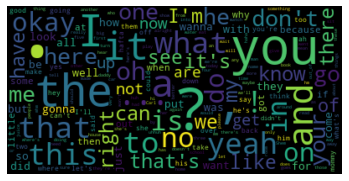

In [14]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

In [15]:
# get freq of all files from UC children for open class words:
from collections import Counter
freq_all = Counter()
for f in range(len(data_idx[data_idx.ses == 'UC'].file_path)):  # same file list used to read 'samples'
    freq_all.update(get_freq(f_UC, 'CHI', POS_OPEN, file_idx=f))
freq_all.most_common(20)

[('yeah', 5369),
 ('no', 3146),
 ('go', 2036),
 ('there', 1694),
 ('oh', 1650),
 ('here', 1463),
 ('wanna', 1360),
 ('know', 1323),
 ('do', 1284),
 ('want', 1247),
 ('okay', 1221),
 ('get', 1220),
 ('see', 1184),
 ('have', 1144),
 ('now', 1113),
 ('look', 1013),
 ('right', 1011),
 ('ah', 1003),
 ('put', 1000),
 ('up', 949)]

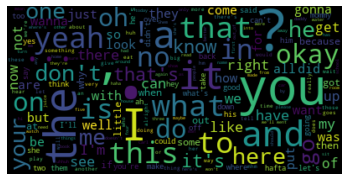

In [16]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

---

# 5 Summary
